# Analyse function similarity between IUPRED3 and AlphaFold pLDDT
Select 1000 random structures, get their pLDDT and IUPRED3 scores and calculate Spearman's r

In [8]:
import glob
import gzip
import re
import requests

import pandas as pd
import numpy as np

from pqdm.threads import pqdm
from bin.iupred3.iupred3_lib import iupred
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [24]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [8]:
random_uniprot_ids = df.loc[(df['seq_len'] > 20) & (df['proteome'] != 'HUMAN')][['uniprot_id', 'proteome']].sample(
    n=5000).values

In [9]:
def get_plddt_scores(uniprot_id: str, proteome: str):
    pLDDT_scores = []
    with gzip.open(glob.glob(f'../data/alphafold/v2/*_{proteome}_v2/AF-{uniprot_id}-*.pdb.gz')[0], "rt") as handle:
        seen_res_i = 0
        for line in handle:
            # The pLDDT is the last number in each ATOM line
            if line.startswith('ATOM'):
                res_i = int(line[22:27])
                if res_i != seen_res_i:
                    seen_res_i = res_i
                    pLDDT = float(line[-20:-13])
                    pLDDT_scores.append(pLDDT)
    return np.asarray(pLDDT_scores)


def load_sequence_from_uniprot(uniprot_id: str) -> str:
    res = ''
    try:
        response = requests.get(f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta").text
        for decoded in response.split('\n'):
            if not decoded.startswith('>'):
                res += decoded
    except Exception as e:
        print(f'Failed fetching sequence: {e.message if hasattr(e, "message") else e}')
        pass
    return res


def get_iupred_scores(uniprot_id: str):
    seq = load_sequence_from_uniprot(uniprot_id)
    if seq is None:
        return None
    try:
        res = iupred(seq, 'long')
        return res[0]
    except:
        print(f'Error in {seq}')


def calculate_spearman(entry):
    try:
        plddts = get_plddt_scores(entry[0], entry[1])
        iupreds = get_iupred_scores(entry[0])
        rho, p = spearmanr(plddts, iupreds)
        return rho
    except:
        print(f'Error in {entry[0]}')
        return None

In [3]:
rhos = pqdm(random_uniprot_ids, calculate_spearman, n_jobs=10, desc='Sequences')

In [25]:
df_spearman = df[df['iupred_plddt_spearman'].notnull()].copy()
df_spearman['iupred_auc_normalized'] = df_spearman['iupred_auc'] / df_spearman['seq_len']
df_spearman.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,iupred_auc_normalized
count,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000
mean,418.879011,0.570520,30.831542,33.827475,75.295734,79.046136,0.356741,126.058216,0.516297,0.000656,0.584466,0.019510,-0.311983,0.756153,0.973968,0.160893,0.287498
std,343.376647,1.107859,1.480995,11.474122,15.024180,18.828361,0.292590,147.567754,4.490001,0.048519,4.744459,0.390805,0.317159,5.024768,3.622326,0.063942,0.175203
min,20.000000,0.000000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.987435,0.000000,0.000000,0.030443,0.000000
25%,184.000000,0.000000,30.900000,25.650000,64.819100,64.350000,0.112000,37.979450,0.000000,0.000000,0.000000,0.000000,-0.564031,0.000000,0.000000,0.114615,0.162901
50%,330.000000,0.000000,31.300000,31.230000,77.945700,87.310000,0.274000,79.952200,0.000000,0.000000,0.000000,0.000000,-0.345583,0.000000,0.000000,0.148000,0.255789
75%,534.000000,1.000000,31.400000,38.710000,87.670100,94.025000,0.556400,156.599100,0.000000,0.000000,0.000000,0.000000,-0.103957,0.000000,1.000000,0.193025,0.387481
max,2699.000000,46.000000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900,342.000000,11.000000,382.000000,83.000000,0.918797,386.000000,673.000000,0.713420,7.224074


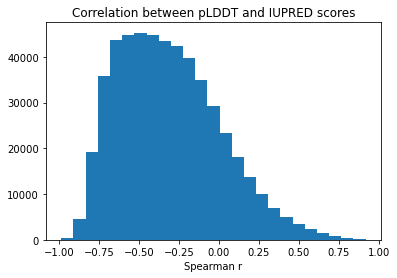

In [6]:
% matplotlib inline
fig, ax = plt.subplots()
ax.hist(df_spearman['iupred_plddt_spearman'].values, bins=25)
ax.set_title('Correlation between pLDDT and IUPRED scores')
ax.set_xlabel('Spearman r')
plt.show()

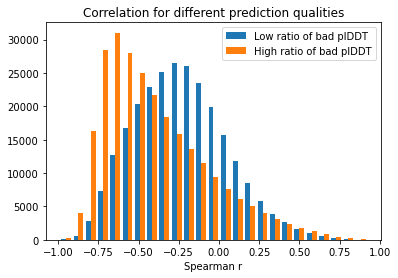

In [45]:
% matplotlib inline
fig, ax = plt.subplots()

median = df_spearman['ratio_bad_plddt'].median()
good_values = df_spearman[df_spearman['ratio_bad_plddt'] <= median]['iupred_plddt_spearman'].values
bad_values = df_spearman[df_spearman['ratio_bad_plddt'] > median]['iupred_plddt_spearman'].values

ax.hist([good_values, bad_values], bins=25, label=['Low ratio of bad plDDT', 'High ratio of bad plDDT'])
ax.set_title('Correlation for different prediction qualities')
ax.set_xlabel('Spearman r')

plt.legend()
plt.show()

You can definitely see a significant correlation between both scores for most of the sequences. As expected, a low pLDDT often means high IUPRED score. However, we also see that there are outliers where a low pLDDT correlates with a low IUPRED. This might be connected to the sequences we found earlier with a high ratio of bad pLDDTs and a low IUPRED AUC. Vikram found those to be disordered and we expect IUPRED to be bad for those.

In [32]:
df_spearman.nsmallest(10, columns=['iupred_plddt_spearman'])[['iupred_plddt_spearman', 'iupred_auc_normalized']].mean()

iupred_plddt_spearman   -0.971244
iupred_auc_normalized    0.160105
dtype: float64

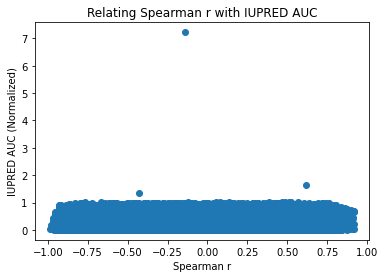

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(df_spearman['iupred_plddt_spearman'].values, df_spearman['iupred_auc_normalized'].values)
ax.set_title('Relating Spearman r with IUPRED AUC')
ax.set_xlabel('Spearman r')
ax.set_ylabel('IUPRED AUC (Normalized)')
plt.show()

### Cut out between -0.3 and 0.3 to investigate their function
Read GO functions and processes and compare their frequencies for the uncorrelated vs correlated as well as positively correlated vs all.

In [31]:
#df_uncorrelated = df_spearman[df_spearman['iupred_plddt_spearman'].between(-0.3, 0.3)][
#    ['uniprot_id', 'seq_len', 'iupred_auc', 'ratio_bad_plddt' ,'iupred_plddt_spearman']].copy().reset_index()
df_uncorrelated = pd.read_csv('../data/interesting_sequences/uncorrelated_iupred_plddt.csv', na_values='')
#df_uncorrelated.to_csv('../data/interesting_sequences/uncorrelated_iupred_plddt.csv')

#df_correlated = df_spearman[df_spearman['iupred_plddt_spearman'].between(-0.3, 0.3).replace(...)][
#    ['uniprot_id', 'seq_len', 'iupred_auc', 'ratio_bad_plddt' ,'iupred_plddt_spearman']].copy().reset_index()
df_correlated = pd.read_csv('../data/interesting_sequences/correlated_iupred_plddt.csv', na_values='')
#df_uncorrelated.to_csv('../data/interesting_sequences/uncorrelated_iupred_plddt.csv')

In [3]:
from tqdm.auto import tqdm
from aiohttp import ClientSession

In [7]:
async def load_go_data(session: ClientSession, uniprot_id: str) -> [str]:
    try:
        response = await session.get(url=f"https://www.uniprot.org/uniprot/{uniprot_id}.txt")
        go_function = []
        go_process = []
        async for line in response.content:
            dec = line.decode()
            if dec.startswith('DR   GO; GO:'):
                if dec[21] == 'F':
                    go_function.append(dec[23:dec.find(';', 23)])
                elif dec[21] == 'P':
                    go_process.append(dec[23:dec.find(';', 23)])
        return ';'.join(go_function), ';'.join(go_process)
    except:
        pass
    return '', ''

async def extend_with_go_data(session: ClientSession):
    if 'go_function' not in df_uncorrelated:
        df_uncorrelated['go_function'] = None
    if 'go_process' not in df_uncorrelated:
        df_uncorrelated['go_process'] = None
    to_fill = df_uncorrelated[df_uncorrelated['go_function'].isnull()].index
    if len(to_fill) == 0:
        print('Already filled with go data')
        return
    splits = np.array_split(to_fill, len(to_fill) / 10000 + 1)
    for i, fill_split in enumerate(splits):
        go_data = await tqdm.gather(
            *[load_go_data(session, uid) for uid in df_uncorrelated['uniprot_id'][fill_split]],
            desc=f'Sequences split {i + 1}/{len(splits)}')
        df_uncorrelated.loc[fill_split, ['go_function', 'go_process']] = go_data
        df_uncorrelated.to_csv(f'../data/interesting_sequences/uncorrelated_iupred_plddt.csv')

In [12]:
async with ClientSession() as session:
    await extend_with_go_data(session)

Already filled with go data


In [33]:
print(f'There are a total of {len(df_correlated)} correlated sequences. Of those, {(df_correlated["go_function"].isna()).sum()} have no GO functions and {df_correlated["go_process"].isna().sum()} have no GO processes.')
print(f'There are a total of {len(df_uncorrelated)} uncorrelated sequences. Of those, {(df_uncorrelated["go_function"].isna()).sum()} have no GO functions and {df_uncorrelated["go_process"].isna().sum()} have no GO processes.')

There are a total of 304026 correlated sequences. Of those, 145233 have no GO functions and 167739 have no GO processes.
There are a total of 209465 uncorrelated sequences. Of those, 91134 have no GO functions and 118462 have no GO processes.


### Plot differences between correlated and uncorrelated GO functions and processes

In [65]:
uncorrelated_functions_without_na = df_uncorrelated['go_function'].dropna()
uncorrelated_functions_counts = uncorrelated_functions_without_na.apply(lambda x: x.split(';')).explode().value_counts()
uncorrelated_function_freq = uncorrelated_functions_counts / len(uncorrelated_functions_without_na)

uncorrelated_processes_without_na = df_uncorrelated['go_process'].dropna()
uncorrelated_processes_counts = uncorrelated_processes_without_na.apply(lambda x: x.split(';')).explode().value_counts()
uncorrelated_process_freq = uncorrelated_processes_counts / len(uncorrelated_processes_without_na)

In [66]:
correlated_functions_without_na = df_correlated['go_function'].dropna()
correlated_functions_counts = correlated_functions_without_na.apply(lambda x: x.split(';')).explode().value_counts()
correlated_function_freq = correlated_functions_counts / len(correlated_functions_without_na)

correlated_processes_without_na = df_correlated['go_process'].dropna()
correlated_processes_counts = correlated_processes_without_na.apply(lambda x: x.split(';')).explode().value_counts()
correlated_process_freq = correlated_processes_counts / len(correlated_processes_without_na)

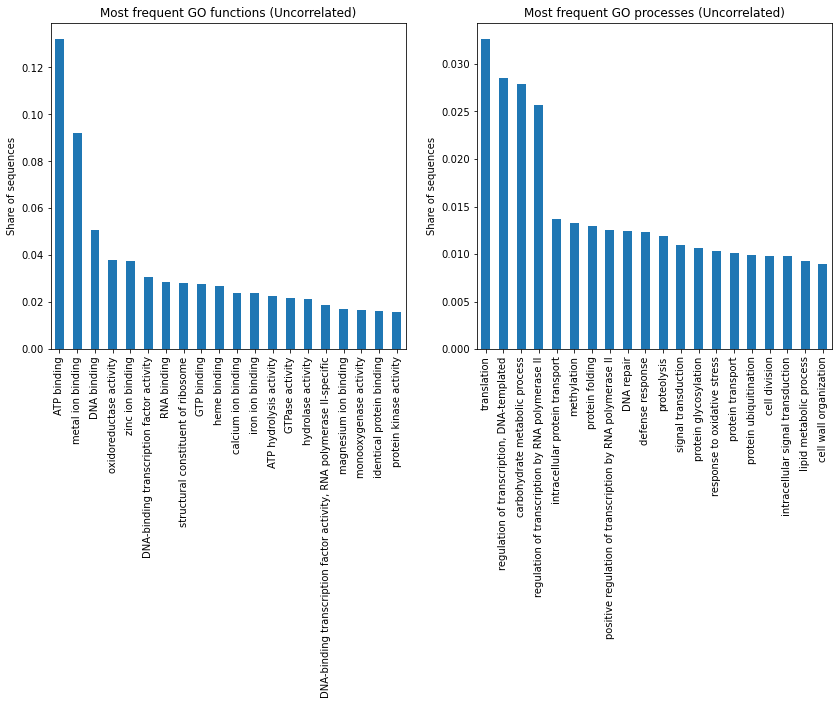

In [36]:
%matplotlib inline

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

uncorrelated_function_freq.head(20).plot(kind='bar', ax=ax1)
ax1.set_title('Most frequent GO functions (Uncorrelated)')
ax1.set_ylabel('Share of sequences')

uncorrelated_process_freq.head(20).plot(kind='bar', ax=ax2)
ax2.set_title('Most frequent GO processes (Uncorrelated)')
ax2.set_ylabel('Share of sequences')

plt.show()

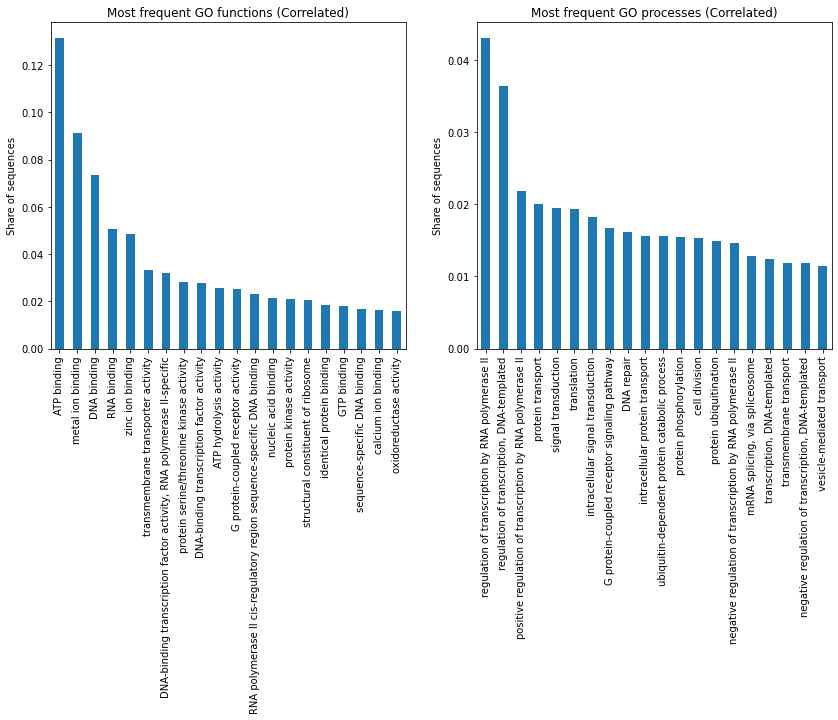

In [10]:
%matplotlib inline

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

correlated_function_freq.head(20).plot(kind='bar', ax=ax1)
ax1.set_title('Most frequent GO functions (Correlated)')
ax1.set_ylabel('Share of sequences')

correlated_process_freq.head(20).plot(kind='bar', ax=ax2)
ax2.set_title('Most frequent GO processes (Correlated)')
ax2.set_ylabel('Share of sequences')

plt.show()

In [79]:
df_difference_function = pd.concat([uncorrelated_function_freq, correlated_function_freq], axis=1).fillna(0)
df_difference_function.columns = ['go_function_uncorrelated', 'go_function_correlated']
df_difference_function['go_function_diff'] = df_difference_function['go_function_uncorrelated'] - df_difference_function['go_function_correlated']
df_difference_function_sorted = df_difference_function.iloc[df_difference_function['go_function_diff'].abs().argsort()[::-1]]
df_difference_function_sorted.head(5)

,go_function_uncorrelated,go_function_correlated,go_function_diff
transmembrane transporter activity,0.006051,0.033043,-0.026992
DNA binding,0.050832,0.073492,-0.022660
oxidoreductase activity,0.037961,0.015700,0.022262
RNA binding,0.028479,0.050493,-0.022014
G protein-coupled receptor activity,0.003794,0.025379,-0.021585


In [80]:
df_difference_process = pd.concat([uncorrelated_process_freq, correlated_process_freq], axis=1).fillna(0)
df_difference_process.columns = ['go_process_uncorrelated', 'go_process_correlated']
df_difference_process['go_process_diff'] = df_difference_process['go_process_uncorrelated'] - df_difference_process['go_process_correlated']
df_difference_process_sorted = df_difference_process.iloc[df_difference_process['go_process_diff'].abs().argsort()[::-1]]
df_difference_process_sorted.head(5)

,go_process_uncorrelated,go_process_correlated,go_process_diff
carbohydrate metabolic process,0.027922,0.009649,0.018273
regulation of transcription by RNA polymerase II,0.025702,0.043108,-0.017405
translation,0.032669,0.019393,0.013276
G protein-coupled receptor signaling pathway,0.004187,0.016685,-0.012499
protein transport,0.010099,0.020119,-0.010021


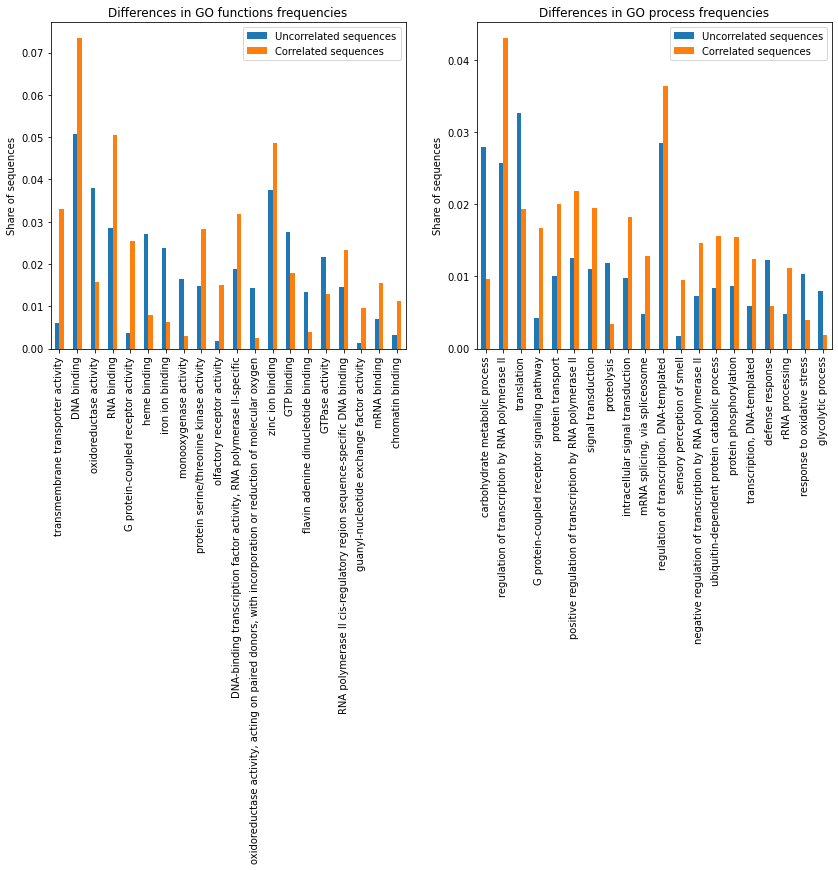

In [83]:
%matplotlib inline

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

df_difference_function_sorted.head(20)[['go_function_uncorrelated', 'go_function_correlated']].plot(kind='bar', ax=ax1)
ax1.set_title('Differences in GO functions frequencies')
ax1.set_ylabel('Share of sequences')
ax1.legend(['Uncorrelated sequences', 'Correlated sequences'])

df_difference_process_sorted.head(20)[['go_process_uncorrelated', 'go_process_correlated']].plot(kind='bar', ax=ax2)
ax2.set_title('Differences in GO process frequencies')
ax2.set_ylabel('Share of sequences')
ax2.legend(['Uncorrelated sequences', 'Correlated sequences'])

plt.show()

### Plot differences between positively correlated (wrong) and all sequences

In [87]:
df_positively_correlated = df_correlated[df_correlated['iupred_plddt_spearman'] > 0.3]
df_positively_correlated.describe()

,Unnamed: 0,index,seq_len,iupred_auc,ratio_bad_plddt,iupred_plddt_spearman
count,21417.000000,21417.000000,21417.000000,21417.000000,21417.000000,21417.000000
mean,164964.270439,11714.350609,197.408040,52.852152,0.421379,0.452724
std,91684.998317,12030.530880,164.739992,70.236452,0.357455,0.122699
min,4.000000,0.000000,20.000000,0.000100,0.000000,0.300011
25%,85527.000000,3076.000000,100.000000,17.136700,0.119600,0.353395
50%,166068.000000,7425.000000,149.000000,33.528800,0.272700,0.421891
75%,251006.000000,16181.000000,241.000000,63.196200,0.793100,0.527389
max,304012.000000,55788.000000,2637.000000,1937.439800,1.000000,0.918797


Comparing the mean IUPred AUC and ratio bad pLDDT of the positively correlated (52.85, 0.42) vs those of all sequences (125.97, 0.35), we can see that IUPred, on average, predicts less disorder and AlphaFold has more regions of bad pLDDTs for the positively correlated.

In [67]:
# Get frequencies of GO functions and processes for sequences with positive correlation (>0.3).
positively_correlated_functions_without_na = df_positively_correlated['go_function'].dropna()
positively_correlated_functions_counts = positively_correlated_functions_without_na.apply(lambda x: x.split(';')).explode().value_counts()
positively_correlated_function_freq = positively_correlated_functions_counts / len(positively_correlated_functions_without_na)

processes_correlated_processes_without_na = df_positively_correlated['go_process'].dropna()
positively_correlated_processes_counts = processes_correlated_processes_without_na.apply(lambda x: x.split(';')).explode().value_counts()
positively_correlated_process_freq = positively_correlated_processes_counts / len(processes_correlated_processes_without_na)

In [68]:
# Get overall frequencies of GO functions and processes for all sequences
all_function_freq = uncorrelated_functions_counts.add(correlated_functions_counts, fill_value=0).sort_values()[::-1] / (
            len(uncorrelated_functions_without_na) + len(correlated_functions_without_na))
all_process_freq = uncorrelated_processes_counts.add(correlated_processes_counts, fill_value=0).sort_values()[::-1] / (
            len(uncorrelated_processes_without_na) + len(correlated_processes_without_na))

In [75]:
df_difference_function_p = pd.concat([all_function_freq, positively_correlated_function_freq], axis=1).fillna(0)
df_difference_function_p.columns = ['go_function_all', 'go_function_positively_correlated']
df_difference_function_p['go_function_diff'] = df_difference_function_p['go_function_all'] - df_difference_function_p['go_function_positively_correlated']
df_difference_function_p_sorted = df_difference_function_p.iloc[df_difference_function_p['go_function_diff'].abs().argsort()[::-1]]
df_difference_function_p_sorted.head(5)

,go_function_all,go_function_positively_correlated,go_function_diff
ATP binding,0.131818,0.049149,0.082669
structural constituent of ribosome,0.023906,0.066304,-0.042397
metal ion binding,0.091555,0.050238,0.041316
antigen binding,0.001277,0.029272,-0.027994
immunoglobulin receptor binding,0.001148,0.027910,-0.026763


In [82]:
df_difference_process_p = pd.concat([all_process_freq, positively_correlated_process_freq], axis=1).fillna(0)
df_difference_process_p.columns = ['go_process_all', 'go_process_positively_correlated']
df_difference_process_p['go_process_diff'] = df_difference_process_p['go_process_all'] - df_difference_process_p['go_process_positively_correlated']
df_difference_process_p_sorted = df_difference_process_p.iloc[df_difference_process_p['go_process_diff'].abs().argsort()[::-1]]
df_difference_process_p_sorted.head(5)

,go_process_all,go_process_positively_correlated,go_process_diff
translation,0.024709,0.065743,-0.041034
immune response,0.004268,0.044958,-0.040690
defense response to bacterium,0.005011,0.041878,-0.036867
innate immune response,0.007427,0.040185,-0.032758
"complement activation, classical pathway",0.001681,0.031871,-0.030190


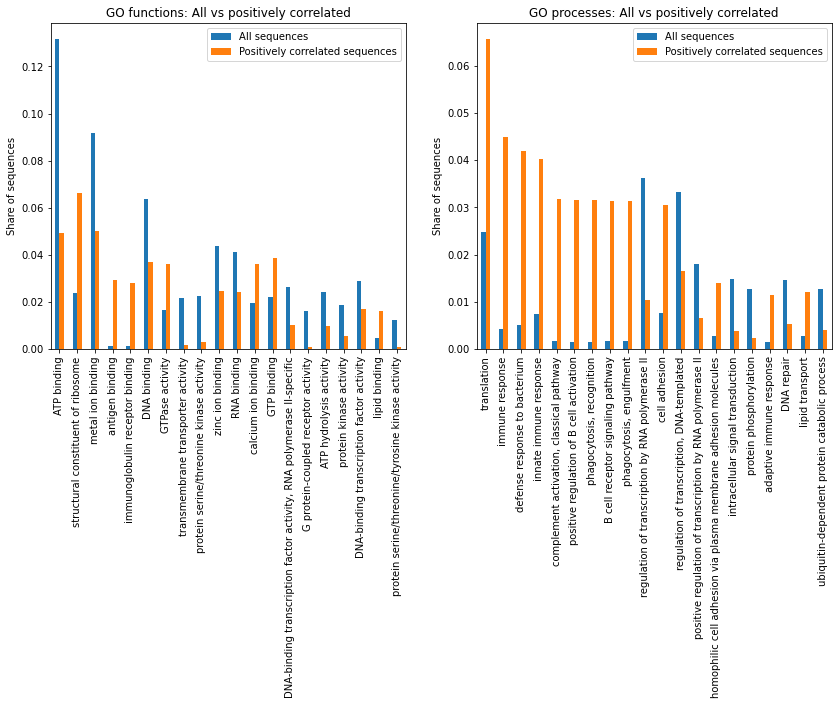

In [85]:
%matplotlib inline

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

df_difference_function_p_sorted.head(20)[['go_function_all', 'go_function_positively_correlated']].plot(kind='bar', ax=ax1)
ax1.set_title('GO functions: All vs positively correlated')
ax1.set_ylabel('Share of sequences')
ax1.legend(['All sequences', 'Positively correlated sequences'])

df_difference_process_p_sorted.head(20)[['go_process_all', 'go_process_positively_correlated']].plot(kind='bar', ax=ax2)
ax2.set_title('GO processes: All vs positively correlated')
ax2.set_ylabel('Share of sequences')
ax2.legend(['All sequences', 'Positively correlated sequences'])

plt.show()

In [96]:
# Inspect some immuno globulin proteins to confirm
df_positively_correlated[df_positively_correlated['go_function'].str.contains('antigen binding', na=False)].sort_values(by='iupred_plddt_spearman', ascending=False)

,Unnamed: 0,index,uniprot_id,seq_len,iupred_auc,ratio_bad_plddt,iupred_plddt_spearman,go_function,go_process
44363,44363,11898,M9MMC6,130,30.3030,0.0462,0.754827,antigen binding;immunoglobulin receptor binding,B cell receptor signaling pathway;complement a...
41051,41051,6717,M9MMC5,126,31.6520,0.1587,0.744241,antigen binding;immunoglobulin receptor binding,B cell receptor signaling pathway;complement a...
68869,68869,3768,A0A0G2JFX6,112,26.4976,0.1518,0.729743,peptide antigen binding,NaN
78060,78060,17375,A0A0G2LB96,114,16.5149,0.1754,0.707557,peptide antigen binding,cell surface receptor signaling pathway
69142,69142,4170,A0A075B5R9,117,26.0067,0.1624,0.703189,antigen binding;immunoglobulin receptor binding,B cell receptor signaling pathway;complement a...
...,...,...,...,...,...,...,...,...,...
79284,79284,19136,P79568,326,82.1839,0.1472,0.305320,14-3-3 protein binding;beta-2-microglobulin bi...,antigen processing and presentation of endogen...
42200,42200,8525,X1WGT4,114,17.5958,0.2719,0.302458,antigen binding;immunoglobulin receptor binding,B cell receptor signaling pathway;complement a...
80057,80057,20284,P01797,113,23.1445,0.0000,0.301799,antigen binding;immunoglobulin receptor binding,B cell receptor signaling pathway;complement a...
68232,68232,2804,P01800,113,21.4964,0.0000,0.301481,antigen binding;immunoglobulin receptor binding,B cell receptor signaling pathway;complement a...


## How good is our naive approach for correlated sequences?

In [ ]:
df_correlated = df_spearman[df_spearman['iupred_plddt_spearman'].between(-0.3, 0.3).replace(to_replace=[True, False], value=[False, True])].copy()

In [57]:
# Use 6mer counts of 2k most common and normalize
df_correlated['repeat_6mers'] = df_correlated['repeat_6mers_2000']
df_correlated['non_repeat_6mers'] = df_correlated['non_repeat_6mers_2000']
df_correlated = df_correlated[(df_correlated['repeat_6mers'].notnull() & df_correlated['non_repeat_6mers'].notnull() & df_correlated['aa_distr_js'].notnull())].copy()
df_correlated['repeat_6mers_normalized'] = df_correlated['repeat_6mers'] / df_correlated['seq_len']
df_correlated['non_repeat_6mers_normalized'] = df_correlated['non_repeat_6mers'] / df_correlated['seq_len']

In [58]:
df_correlated = df_correlated[df_correlated['iupred_auc'].notnull()]
df_correlated['iupred_auc_normalized'] = df_correlated['iupred_auc'] / df_correlated['seq_len']

In [59]:
from scipy.stats import spearmanr

In [65]:
features = ['iupred_auc_normalized', 'repeat_6mers_normalized', 'non_repeat_6mers_normalized', 'aa_distr_js']
w = np.asarray([0.17525,0.26599,0.23276,0.34607])
rho, p = spearmanr(df_correlated['ratio_bad_plddt'], df_correlated[features] @ w)
print(f'Spearman rank correlation (Unoptimized): {"{0:.4f}".format(rho)}')

Spearman rank correlation (Unoptimized): 0.5683


- Hydrophobicity, -phily, charge
- Do GO analysis for other part too, plot difference of frequencies between uncorrelated-all and uncorrelated-correlated. Check for how many is known or not
- Combine protein set with nr90, cluster with DeepClust (ask Vikram). Does it divide space?
- Cut 1000 random sequences into 6mers, correlate all scores from aaindex with them and note down 10 abs highest correlating for each 6mer. Investigate how to best condense into one value => this is why alphafold does good, bad
- https://www.genome.jp/aaindex/ or https://www.genome.jp/ftp/db/community/aaindex/aaindex1